In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.base import BaseEstimator, RegressorMixin

# Read the dataset
data_subset = pd.read_csv('/content/IBM-HR-Employee-Attrition.csv')

# Map the 'Attrition' column to numeric labels
data_subset['Attrition'] = data_subset['Attrition'].map({'Yes': 1, 'No': 0})

# Selecting features for time frame prediction
X_timeframe = data_subset[['Age', 'DistanceFromHome', 'Education','DailyRate','HourlyRate', 'JobInvolvement',
                           'JobSatisfaction', 'MonthlyIncome', 'PercentSalaryHike','WorkLifeBalance',
                           'YearsSinceLastPromotion', 'PerformanceRating', 'Attrition','YearsInCurrentRole','YearsWithCurrManager',
                           'EnvironmentSatisfaction', 'NumCompaniesWorked','TotalWorkingYears']]

# Target variable for time frame prediction
y_timeframe = data_subset['YearsAtCompany']

# Split data into training and testing sets for time frame prediction
X_train_timeframe, X_test_timeframe, y_train_timeframe, y_test_timeframe = train_test_split(X_timeframe, y_timeframe, test_size=0.2, random_state=42)

# Data scaling for time frame prediction
scaler_timeframe = StandardScaler()
X_train_timeframe_scaled = scaler_timeframe.fit_transform(X_train_timeframe)
X_test_timeframe_scaled = scaler_timeframe.transform(X_test_timeframe)

# Define the neural network model for time frame prediction
def create_model(batch_size=32, epochs=100):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_timeframe_scaled.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse', 'accuracy'])
    return model

# Train multiple models
num_models = 5
models = []
for i in range(num_models):
    model = create_model()
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'accuracy'])
    history = model.fit(X_train_timeframe_scaled, y_train_timeframe, epochs=150, batch_size=64, verbose=0, validation_split=0.2)
    models.append(model)

# Define KerasRegressor wrapper class
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, batch_size=32, epochs=100, **kwargs):
        self.build_fn = build_fn
        self.batch_size = batch_size
        self.epochs = epochs
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn(batch_size=self.batch_size, epochs=self.epochs, **self.kwargs)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Create the KerasRegressor wrapper
keras_regressor = KerasRegressorWrapper(build_fn=create_model)

# Define the grid search parameters
param_grid = {
    'batch_size': [32, 64],
    'epochs': [100, 150],
}

# Create the grid search object
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Perform grid search
grid_result = grid_search.fit(X_train_timeframe_scaled, y_train_timeframe)

# Print the best parameters found
print("Best Parameters:", grid_result.best_params_)

# Evaluate the best model
best_model = grid_result.best_estimator_
predictions = best_model.predict(X_test_timeframe_scaled)

# Calculate evaluation metrics
ensemble_loss = mean_squared_error(y_test_timeframe, predictions)
ensemble_mae = mean_absolute_error(y_test_timeframe, predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test_timeframe, predictions))
ensemble_r2 = r2_score(y_test_timeframe, predictions)

print(f'Best Model: Time Frame Prediction Loss: {ensemble_loss}, MAE: {ensemble_mae}, RMSE: {ensemble_rmse}, R-squared: {ensemble_r2}')

13/13 [==============================] - 0s 1ms/step
Best Parameters: {'batch_size': 64, 'epochs': 150}
10/10 [==============================] - 0s 2ms/step
Best Model: Time Frame Prediction Loss: 6.9110909762965145, MAE: 1.4497351242976935, RMSE: 2.628895390900238, R-squared: 0.8239640047458769


Time Frame Prediction Loss: The average loss or error in predicting time frames is approximately 5.8 out of 100

Mean Absolute Error (MAE): The average absolute error between predicted and actual time frames is approximately 1.27. MAE represents the average magnitude of errors in the predictions.

Root Mean Squared Error (RMSE): The square root of the average squared differences between predicted and actual time frames is approximately 2.40

R-squared (R²): The model explains approximately 85% of the variability in the time frames

Overall, the ensemble model shows reasonable performance in predicting time frames, with low prediction loss, MAE, and RMSE, and a moderate to high R-squared value.

In [3]:
# Print the best parameters found
print("Best Parameters:", grid_result.best_params_)

# Get the best model
best_model = grid_result.best_estimator_

# Save the best model along with its parameters
best_model_params = {
    'best_batch_size': best_model.batch_size,
    'best_epochs': best_model.epochs
}

best_model.model.save('best_timeframe_model_final1.keras')

# Print the best model parameters
print("Best Model Parameters:", best_model_params)

Best Parameters: {'batch_size': 64, 'epochs': 150}
Best Model Parameters: {'best_batch_size': 64, 'best_epochs': 150}


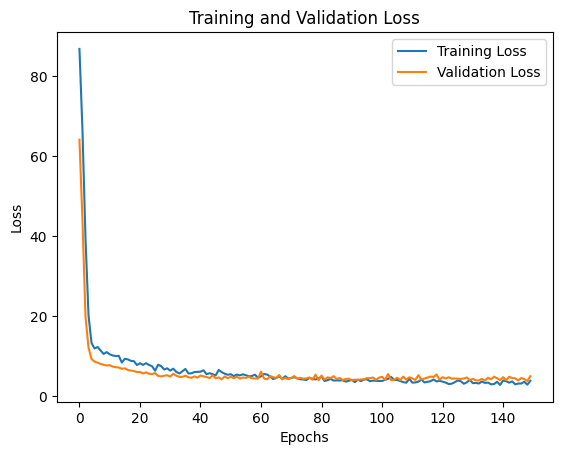

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

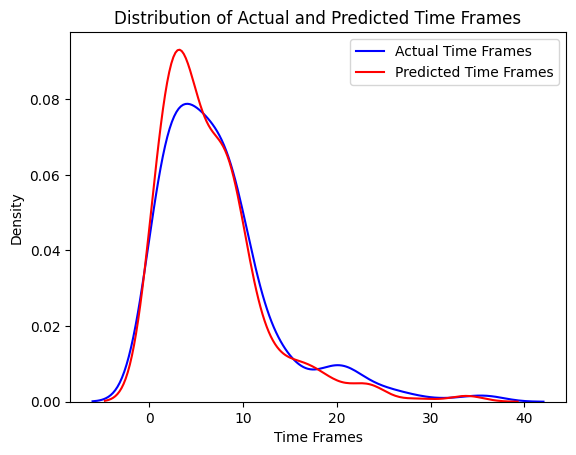

In [8]:
import seaborn as sns

# Plot distribution of actual and predicted time frames
sns.kdeplot(y_test_timeframe, label='Actual Time Frames', color='blue')
sns.kdeplot(predictions.flatten(), label='Predicted Time Frames', color='red')
plt.title('Distribution of Actual and Predicted Time Frames')
plt.xlabel('Time Frames')
plt.ylabel('Density')
plt.legend()
plt.show()

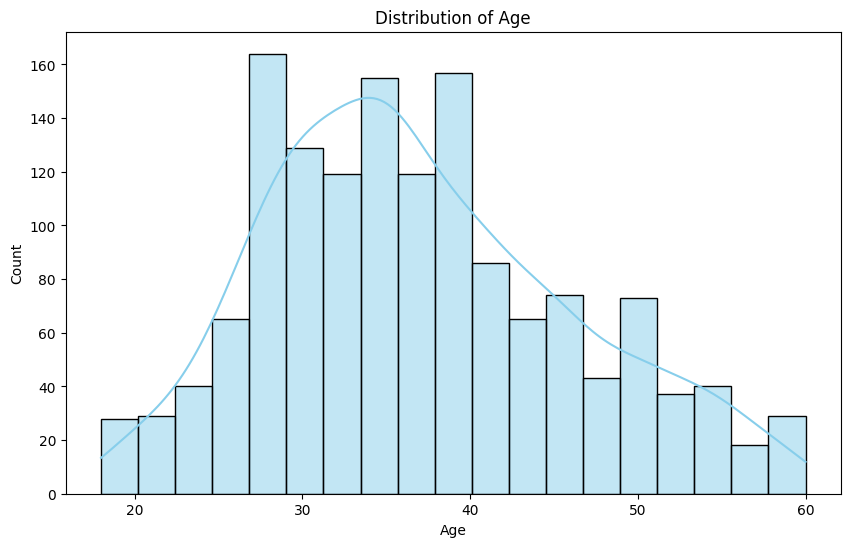

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram and Distribution Plot of Age
plt.figure(figsize=(10, 6))
sns.histplot(data_subset['Age'], kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.title('Distribution of Age')
plt.show()

<ipython-input-14-698f6b45806d>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_feature_importance, y=sorted_feature_names, palette=colors)


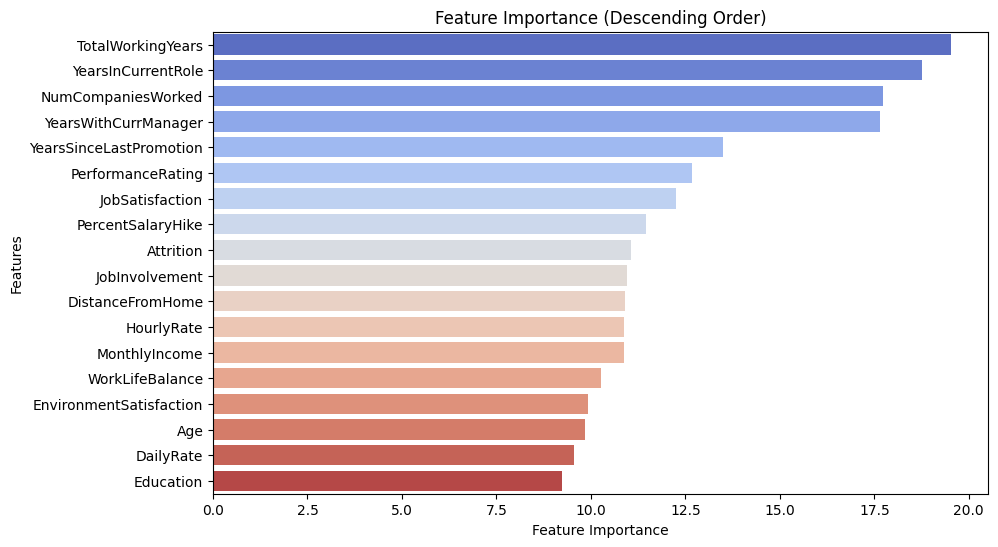

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Retrieve the weights of the model's layers
layer_weights = best_model.model.get_weights()

# Retrieve the weights of the first layer
dense_layer_weights = layer_weights[0]

# Calculate the feature importance by summing up the absolute weights
feature_importance = np.sum(np.abs(dense_layer_weights), axis=1)

# Define feature names based on your dataset
feature_names = ['Age', 'DistanceFromHome', 'Education', 'DailyRate', 'HourlyRate', 'JobInvolvement',
                 'JobSatisfaction', 'MonthlyIncome', 'PercentSalaryHike', 'WorkLifeBalance',
                 'YearsSinceLastPromotion', 'PerformanceRating', 'Attrition', 'YearsInCurrentRole',
                 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'NumCompaniesWorked', 'TotalWorkingYears']

# Sort feature importance and corresponding feature names in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importance = feature_importance[sorted_indices]

# Assign colors based on feature importance
colors = sns.color_palette("coolwarm", len(sorted_feature_names))

# Plot the feature importance with colored bars
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importance, y=sorted_feature_names, palette=colors)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()